In [1]:
from sqlalchemy import create_engine
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set display options to show more rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [3]:
# Assuming the data is stored in a SQLite database (adjust if different)
engine = create_engine('sqlite:///baseball_data.db')
# df = pd.read_sql("SELECT * FROM statcast_data", engine)  # Replace your_table_name with the actual table name


In [4]:
query = "SELECT * FROM statcast_data LIMIT 500000"
df = pd.read_sql(query, engine)


In [5]:
# Flag strikeouts
df['is_strikeout'] = (df['events'] == 'strikeout').astype(int)

# Assuming this is placed after the existing flags for hits and walks


In [6]:
# Create binary flags for hits and walks
df['is_hit'] = df['events'].isin(['single', 'double', 'triple', 'home_run']).astype(int)
df['is_walk'] = (df['events'] == 'walk').astype(int)


In [7]:
# Aggregate data for pitcher-batter matchups
matchup_stats = df.groupby(['pitcher', 'batter']).agg({
    'is_hit': 'sum',
    'is_walk': 'sum',
    'is_strikeout': 'sum',  # Include strikeouts in the aggregation
    'game_pk': 'count'  # Assuming each row is an at-bat; adjust if necessary
}).reset_index()

matchup_stats.rename(columns={'game_pk': 'at_bats'}, inplace=True)
matchup_stats['batting_average'] = matchup_stats['is_hit'] / matchup_stats['at_bats']
matchup_stats['on_base_percentage'] = (matchup_stats['is_hit'] + matchup_stats['is_walk']) / matchup_stats['at_bats']
# Calculate Strikeout Rate
matchup_stats['strikeout_rate'] = matchup_stats['is_strikeout'] / matchup_stats['at_bats']

In [8]:
print(matchup_stats)

       pitcher  batter  is_hit  is_walk  is_strikeout  at_bats  \
0       424144  458731       0        0             0        3   
1       424144  543305       0        0             0        1   
2       424144  543309       0        0             1        5   
3       424144  544725       0        0             1        5   
4       424144  553993       0        0             1        5   
...        ...     ...     ...      ...           ...      ...   
62725   685503  666915       0        0             0        8   
62726   685503  668227       0        0             1       13   
62727   685503  670032       1        0             0        4   
62728   685503  673357       0        1             0        8   
62729   685503  673490       0        0             0        5   

       batting_average  on_base_percentage  strikeout_rate  
0                 0.00               0.000        0.000000  
1                 0.00               0.000        0.000000  
2                 0.00  

In [9]:
df['winning_team'] = df['post_home_score'] > df['post_away_score']  # Simplification for demonstration
df = df.merge(matchup_stats, on=['pitcher', 'batter'], how='left')

# Encode winning_team as binary target variable
label_encoder = LabelEncoder()
df['winning_team_encoded'] = label_encoder.fit_transform(df['winning_team'])

In [10]:
X = df[['batting_average', 'on_base_percentage', 'strikeout_rate']].fillna(0) 

y = df['winning_team_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [11]:
y_pred = model.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))


Model Accuracy: 0.64371


In [12]:
df['is_home'] = (df['home_team'] == 'YourTeamName').astype(int)  # Replace 'YourTeamName' with the actual team name or logic to handle all teams


In [13]:
X = df[['batting_average', 'on_base_percentage', 'is_home']].fillna(0)

In [14]:
# SMOTE

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming 'X' and 'y' are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Now, use X_train_smote and y_train_smote for training your model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     64324
           1       0.38      0.66      0.48     35676

    accuracy                           0.49    100000
   macro avg       0.53      0.53      0.49    100000
weighted avg       0.57      0.49      0.50    100000



In [15]:
# %%time

# from sklearn.model_selection import GridSearchCV

# #  hyperparameter grid tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)

# # Use the best estimator
# best_model = grid_search.best_estimator_
# y_pred_best = best_model.predict(X_test)
# print("Improved Model Accuracy:", accuracy_score(y_test, y_pred_best))

In [16]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.40      0.50     64324
           1       0.38      0.66      0.48     35676

    accuracy                           0.49    100000
   macro avg       0.53      0.53      0.49    100000
weighted avg       0.57      0.49      0.50    100000

ROC-AUC Score: 0.5303457012901227


In [17]:
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Optionally, predict probabilities for ROC AUC score, etc.
y_pred_proba = xgb_clf.predict_proba(X_test)[:,1]


In [18]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.64328
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     64324
           1       0.51      0.01      0.01     35676

    accuracy                           0.64    100000
   macro avg       0.57      0.50      0.40    100000
weighted avg       0.59      0.64      0.51    100000

ROC AUC Score: 0.5417840367196873


In [19]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Assuming X_train, y_train are already defined and split from your dataset

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)



In [20]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
# Making predictions
y_pred = xgb_clf.predict(X_test)
# For ROC AUC Score calculation
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]


Accuracy: 0.48956
              precision    recall  f1-score   support

           0       0.68      0.39      0.50     64324
           1       0.38      0.67      0.48     35676

    accuracy                           0.49    100000
   macro avg       0.53      0.53      0.49    100000
weighted avg       0.57      0.49      0.49    100000

ROC AUC Score: 0.5412920632697992


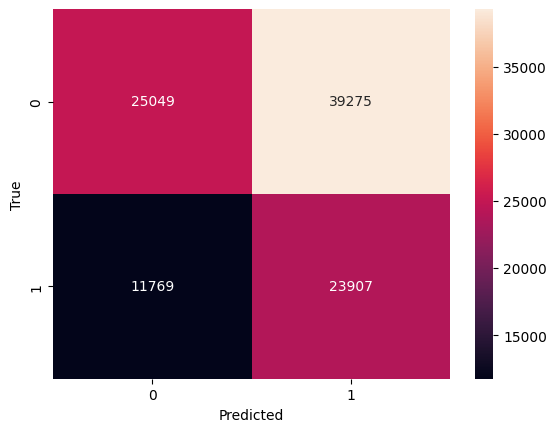

In [49]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [50]:
param_grid = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.7, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}


In [52]:
from sklearn.model_selection import RandomizedSearchCV

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=5, random_state=42)


In [53]:
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc')

In [54]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Best model
best_clf = random_search.best_estimator_


Best Parameters: {'subsample': 1.0, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best Score: 0.5465874784950862


In [55]:
y_pred = best_clf.predict(X_test)
# Evaluate predictions


Accuracy: 0.64337
              precision    recall  f1-score   support

           0       0.64      1.00      0.78     64324
           1       0.52      0.00      0.01     35676

    accuracy                           0.64    100000
   macro avg       0.58      0.50      0.40    100000
weighted avg       0.60      0.64      0.51    100000

ROC AUC Score: 0.5412920632697992


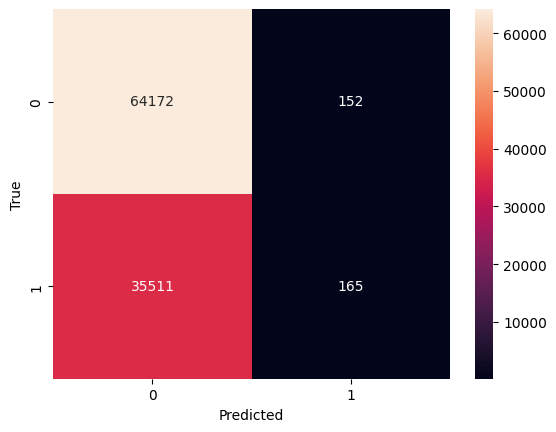

In [56]:

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
param_grid = {
    'xgb__n_estimators': np.arange(50, 400, 50),
    'xgb__max_depth': [3, 4, 5, 6, 7, 8],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__colsample_bytree': [0.3, 0.7, 1.0],
    'xgb__subsample': [0.6, 0.8, 1.0]
}


In [60]:
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE

# Define your pipeline
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Now use the adjusted `param_grid` in `RandomizedSearchCV`
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=100,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            im...
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.3, 0.7,
                                                                  1.0],
                                        'xgb__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2],
                                        'xgb__max_depth': [3, 4, 5, 6, 7, 8],
                                        'xgb__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350]),
                                        'xgb__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc')

In [61]:
# Using the best estimator from the randomized search
best_estimator = random_search.best_estimator_

# Making predictions on the test set
y_pred = best_estimator.predict(X_test)

# For ROC AUC score
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]


In [62]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.48529


In [63]:
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.68      0.37      0.48     64324
           1       0.38      0.69      0.49     35676

    accuracy                           0.49    100000
   macro avg       0.53      0.53      0.49    100000
weighted avg       0.57      0.49      0.48    100000



In [64]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")


ROC AUC Score: 0.5411739057922229


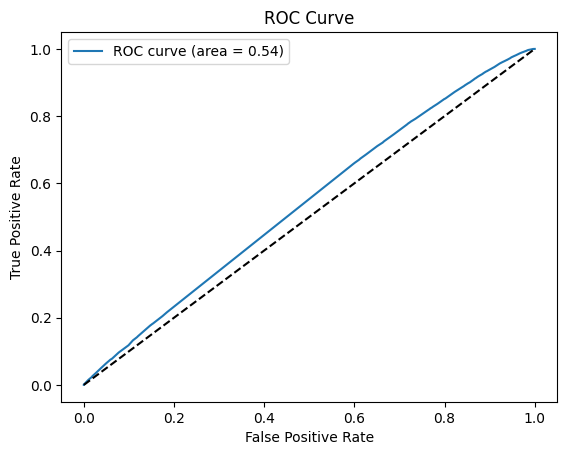

In [65]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [23]:
# TODO CLEANUP BELOW

In [24]:
# df_sorted = df.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'])


# # find last play
# last_play_per_game = df_sorted.drop_duplicates(subset=['game_pk'], keep='last').copy()

# # Now apply changes to 'last_play_per_game', which is a copy to avoid SettingWithCopyWarning
# last_play_per_game['winning_team'] = last_play_per_game.apply(lambda row: row['home_team'] if row['post_home_score'] > row['post_away_score'] else row['away_team'], axis=1)
# last_play_per_game['losing_team'] = last_play_per_game.apply(lambda row: row['away_team'] if row['post_home_score'] > row['post_away_score'] else row['home_team'], axis=1)

# # Selecting the required columns along with game_date
# winners_losers = last_play_per_game[['game_pk', 'game_date', 'winning_team', 'losing_team', 'post_home_score', 'post_away_score', 'home_team', 'away_team']]

# # Reset the index of the DataFrame and drop the old index
# winners_losers_reset_index = winners_losers.reset_index(drop=True)


In [25]:
# print(winners_losers_reset_index)

In [26]:
# hit_types = ['single', 'double', 'triple', 'home_run']
# at_bat_events = hit_types + ['field_out', 'strikeout', 'fielders_choice', 'grounded_into_double_play', 'force_out']
# df['is_hit'] = df['events'].isin(hit_types)
# df['is_at_bat'] = df['events'].isin(at_bat_events)
# df['is_strikeout'] = df['events'] == 'strikeout'
# df['is_walk'] = df['events'] == 'walk'

In [27]:
# stats = df.groupby(["game_pk", 'pitcher', 'batter']).agg({
#     'is_at_bat': 'sum',
#     'is_hit': 'sum',
#     'is_strikeout': 'sum',
#     'is_walk': 'sum',
# }).rename(columns={'is_at_bat': 'at_bats', 'is_hit': 'total_hits', 'is_strikeout': 'strikeouts', 'is_walk': 'walks'})


In [28]:
# stats['batting_average'] = stats['total_hits'] / stats['at_bats']
# stats['on_base_percentage'] = (stats['total_hits'] + stats['walks']) / (stats['at_bats'] + stats['walks'])


In [29]:
# stats.reset_index(inplace=True)

In [30]:
# print(stats)

In [31]:
# data = pd.merge(stats, winners_losers_reset_index, on='game_pk')

In [32]:
# print(data)

In [33]:
# label_encoder = LabelEncoder()
# data['winning_team_encoded'] = label_encoder.fit_transform(data['winning_team'])

In [34]:
# Drop the columns not needed for training
# X = data.drop(['game_pk', 'game_date', 'winning_team', 'losing_team', 'post_home_score', 'post_away_score', 
#                'home_team', 'away_team', 'winning_team_encoded'], axis=1)
# y = data['home_team']


In [35]:
# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Initialize the RandomForestClassifier
# model = RandomForestClassifier(random_state=42)


In [37]:
# Train the model
# model.fit(X_train, y_train)


In [38]:
# Predict on the test set
# y_pred = model.predict(X_test)


In [39]:
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Model accuracy: {accuracy}')


In [40]:
# CODE SHELVED BELOW

In [41]:
# hit_types = ['single', 'double', 'triple', 'home_run']
# at_bat_events = hit_types + ['field_out', 'strikeout', 'fielders_choice', 'grounded_into_double_play', 'force_out', 'strikeout']
# walk_events = ['walk']

In [42]:
# # Create a new column in the DataFrame to flag hits and at_bats
# df['is_hit'] = df['events'].isin(hit_types)
# df['is_at_bat'] = df['events'].isin(at_bat_events)
# df['is_strikeout'] = df['events'] == 'strikeout'
# df['is_walk'] = df['events'] == 'walk'


In [43]:
# # Group by pitcher and batter pairs
# stats = df.groupby(['pitcher', 'batter']).agg({
#     'is_at_bat': 'sum',         # Total number of at-bats
#     'is_hit': 'sum',            # Total number of hits
#     'is_strikeout': 'sum',      # Total number of strikeouts
#     'is_walk': 'sum',           # Total number of walks
# }).rename(columns={'is_at_bat': 'at_bats', 'is_hit': 'total_hits', 'is_strikeout': 'strikeouts', 'is_walk': 'walks'})

In [44]:
# # Calculate batting average (AVG) and on-base percentage (OBP)
# stats['batting_average'] = stats['total_hits'] / stats['at_bats']
# stats['on_base_percentage'] = (stats['total_hits'] + stats['walks']) / (stats['at_bats'] + stats['walks'])

In [45]:
# # Reset index to make 'pitcher' and 'batter' columns again if necessary
# stats.reset_index(inplace=True)

In [46]:
# # Display the statistics DataFrame
# print(stats)

In [47]:
# print(winners_losers_reset_index)